# Load movie rating file
## convert the rating file into a user-item matrix

In [1]:
import numpy as np
import pandas as pd

ratingfile = '/Users/yumei/Downloads/CSE575 machine learning/project/data/ml-100k/u.data'
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(ratingfile, sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

user_item_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    user_item_matrix[line[1] - 1, line[2] - 1] = line[3]

Number of users = 943 | Number of movies = 1682


## Pre-compute the user-user similarity matrix using pearson correlation

In [2]:
import scipy.stats
import scipy.spatial
import math
from math import sqrt

user_similarity_pearson = np.zeros((n_users, n_users))

# compute the similarities in the upper triangle part
for user1 in range(n_users):
    for user2 in range(n_users):
        if(user1 <= user2):
            break
        elif np.count_nonzero(user_item_matrix[user1]) and np.count_nonzero(user_item_matrix[user2]):
            try:
                if not math.isnan(scipy.stats.pearsonr(user_item_matrix[user1], user_item_matrix[user2])[0]):
                    user_similarity_pearson[user1][user2] = scipy.stats.pearsonr(user_item_matrix[user1], user_item_matrix[user2])[0]
                else:
                    user_similarity_pearson[user1][user2] = 0
            except:
                user_similarity_pearson[user1][user2] = 0
                
# complete all entries by  add the transposed similarity matrix to our
# previously computed values                
user_similarity_pearson = user_similarity_pearson + user_similarity_pearson.T

## Pre-compute the item-item similarity matrix using pearson correlation

In [3]:
item_similarity_pearson = np.zeros((n_items, n_items))
data = user_item_matrix.T.copy()
# compute the similarities in the upper triangle part
for item1 in range(n_items):
    for item2 in range(n_items):
        if item1 <= item2:
            break
        elif np.count_nonzero(data[item1]) and np.count_nonzero(data[item2]):
            try:
                if not math.isnan(scipy.stats.pearsonr(data[item1], data[item2])[0]):
                    item_similarity_pearson[item1][item2] = scipy.stats.pearsonr(data[item1], data[item2])[0]
                else:
                    item_similarity_pearson[item1][item2] = 0
            except:
                item_similarity_pearson[item1][item2] = 0
                
# complete all entries by  add the transposed similarity matrix to our
# previously computed values                
item_similarity_pearson = item_similarity_pearson + item_similarity_pearson.T

## Split the user-item matrix set into training set and testing set

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation as cv

# split the data set into training set and testing set
train_data, test_data = cv.train_test_split(df, test_size=0.25)

## Rating predict function based on the the user-user similarity

In [5]:
def userbased_predict_rmse(train,test,user_similarity, n_users, n_items, k):
    # transfer the train set of ratings to user-item matrix
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    train_matrix = np.zeros((n_users, n_items))
    for line in train.itertuples():
        train_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]

    true_rate = []
    pred_rate = []

    for line in test.itertuples():
        user = int(line[1])
        item = int(line[2])
        true_rate.append(line[3])

        item_pred = 3.0

        if np.count_nonzero(train_matrix[user-1]):
            sim_pearson = user_similarity[user - 1]
            # sort the similarities in descending order, find the k similar items which has the largest similarities
            sortedindex = np.argsort(-sim_pearson)
            normal_pearson = 0
            dot = 0
            for i in range(k):
                ind = sortedindex[i]
                # normalize the similarity for the rated items
                normal_pearson += np.absolute(sim_pearson[ind])
                # similarity multiply the ratings
                dot += sim_pearson[ind] * train_matrix[ind][item-1]

            if normal_pearson > 0:
                item_pred = dot / normal_pearson

        if item_pred < 0:
            item_pred = 0

        if item_pred > 5:
            item_pred = 5

        pred_rate.append(item_pred)

    rmse= sqrt(mean_squared_error(true_rate, pred_rate))

    return rmse,pred_rate

## Rating predict function based on the the item-item similarity

In [6]:
def itembased_predict_rmse(train, test, item_similarity, n_users, n_items, k):
    print("compute item based rmse .......")
    # transfer the train set of ratings to user-item matrix
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    
    train_matrix = np.zeros((n_users, n_items))
    for line in train.itertuples():
        train_matrix[line[1] - 1, line[2] - 1] = line[3]

    true_rate = []
    pred_rate = []

    for line in test.itertuples():
        user = line[1]
        item = line[2]
        true_rate.append(line[3])

        item_pred = 3.0

        if np.count_nonzero(train_matrix[:, item - 1]):
            sim_pearson = item_similarity[item - 1]
            # sort the similarities, find the k similar items which has the laest the similarities
            sortedindex = np.argsort(-sim_pearson)
            normal_pearson = 0
            dot = 0
            for i in range(k):
                ind = sortedindex[i]
                # normalize the similarity for the rated items
                normal_pearson += np.absolute(sim_pearson[ind])
                # similarity multiply the ratings
                dot += sim_pearson[ind] * train_matrix[user - 1][ind]

            if normal_pearson > 0:
                item_pred = dot / normal_pearson

        if item_pred < 0:
            item_pred = 0

        if item_pred > 5:
            item_pred = 5

        pred_rate.append(item_pred)

    rmse= sqrt(mean_squared_error(true_rate, pred_rate))

    return rmse,pred_rate

## global baseline method

In [7]:
def global_baseline(train_matrix,n_users,n_items):
    overall_mean_rating = train_matrix.sum()/np.count_nonzero(train_matrix)
    # print("sum: ", train_matrix.sum(), "nonzero: ", np.count_nonzero(train_matrix), "mean: ", overall_mean_rating)
    user_rating_deviation = []
    mean_user = 0
    for user in range(n_users):
        user_ratings = train_matrix[user]
        if np.count_nonzero(user_ratings):
            mean_user = user_ratings.sum()/np.count_nonzero(user_ratings) - overall_mean_rating
        user_rating_deviation.append(mean_user)
    # print(user_rating_deviation)
    
    item_rating_deviation = []
    mean_item = 0
    for item in range(n_items):
        item_ratings = train_matrix[:,item]
        if np.count_nonzero(item_ratings):
            mean_item = item_ratings.sum()/np.count_nonzero(item_ratings) - overall_mean_rating            
        item_rating_deviation.append(mean_item)
    # print(item_rating_deviation)
    
    global_baseline_ratings = np.zeros((n_users, n_items))
    for user in range(n_users):
        for item in range(n_items):
            global_baseline_ratings[user,item] = overall_mean_rating + user_rating_deviation[user] + item_rating_deviation[item]
            if math.isnan(global_baseline_ratings[user,item]):
                print("item: ", item," vs:", item_rating_deviation[item], " user: ",user, " vs ",user_rating_deviation[user] )
                print("overall_mean_rating: " , overall_mean_rating)

    return global_baseline_ratings
    

## hybird CF combining global baseline method with user-based KNN CF

In [8]:
def hybird_predict_rmse(train_matrix,test,global_baseline_ratings,user_similarity, k):
    # transfer the train set of ratings to user-item matrix
     
    test = pd.DataFrame(test)

    true_rate = []
    pred_rate = []

    for line in test.itertuples():
        user = int(line[1])
        item = int(line[2])
        true_rate.append(line[3])

        item_pred = 3.0

        if np.count_nonzero(train_matrix[user-1]):
            sim_pearson = user_similarity[user - 1]
            # sort the similarities, find the k similar items which has the laest the similarities
            sortedindex = np.argsort(-sim_pearson)
            normal_pearson = 0
            dot = 0
            for i in range(k):
                ind = sortedindex[i]
                # normalize the similarity for the rated items
                normal_pearson += np.absolute(sim_pearson[ind])
                # ratings weighted with similarity and subtracted with the global baseline rating
                dot += sim_pearson[ind] * (train_matrix[ind][item-1] - global_baseline_ratings[ind][item-1])

            if normal_pearson > 0:
                item_pred = global_baseline_ratings[user-1][item-1] + dot / normal_pearson
            if math.isnan(item_pred):
                print("user: ",user-1, "item: ", item-1)
                print("baseline_ratings: ", global_baseline_ratings[user-1][item-1])
                print("nor: ",  dot / normal_pearson )
                break

        if item_pred < 0:
            item_pred = 0

        if item_pred > 5:
            item_pred = 5

        pred_rate.append(item_pred)

    rmse= sqrt(mean_squared_error(true_rate, pred_rate))

    return rmse,pred_rate

## Pre-compute the global baseline ratings for training set

In [9]:
train = pd.DataFrame(train_data)
train_matrix = np.zeros((n_users, n_items))
for line in train.itertuples():
    train_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]
    
global_baseline_ratings = global_baseline(train_matrix,n_users, n_items)


## Predict the ratings for the test set using the combined method(linear combine globle baseline method and user based CF)

In [10]:
rmse_hybird = []
for i in range(3,10):
    k =  i
    rmse_u,pred_rate_u = hybird_predict_rmse(train_matrix,test_data,global_baseline_ratings,user_similarity_pearson, k)
    rmse_hybird.append(rmse_u)
    
for i in range(1,11):
    k = 10 * i
    rmse_u,pred_rate_u = hybird_predict_rmse(train_matrix,test_data,global_baseline_ratings,user_similarity_pearson, k)
    rmse_hybird.append(rmse_u)

## Predict the ratings for testing set, and compute the RMSE

In [11]:
rmse_user = []
rmse_item = []

for i in range(3,10):
    k =  i
    rmse_u,pred_rate_u = userbased_predict_rmse(train_data, test_data,user_similarity_pearson, n_users, n_items, k)
    rmse_user.append(rmse_u)
    # item based
    rmse_i,pred_rate_i = itembased_predict_rmse(train_data, test_data,item_similarity_pearson, n_users, n_items, k)
    rmse_item.append(rmse_i) 

compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......


In [12]:

for i in range(1,11):
    k = 10 * i
    # user based
    rmse_u,pred_rate_u = userbased_predict_rmse(train_data, test_data,user_similarity_pearson, n_users, n_items, k)
    rmse_user.append(rmse_u)
    # item based
    rmse_i,pred_rate_i = itembased_predict_rmse(train_data, test_data,item_similarity_pearson, n_users, n_items, k)
    rmse_item.append(rmse_i)    


compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......
compute item based rmse .......


In [13]:
print("user based rmse: ", rmse_user)
print("item based rmse: ", rmse_item)
print("bybrid based rmse: ", rmse_hybird)
m = np.zeros((17, 3))
j = 0
for i in range(17):
    m[i][j] = rmse_user[i]
j = 1
for i in range(17):
    m[i][j] = rmse_item[i]
j = 2
for i in range(17):
    m[i][j] = rmse_hybird[i]

print(m)

user based rmse:  [2.5232071768261957, 2.4869231033246066, 2.4692775439128254, 2.4575663651950896, 2.4521704553944663, 2.446238854672891, 2.4451138797608643, 2.4463922524497725, 2.461998572876158, 2.4865830503201782, 2.511113354949078, 2.5324160908453366, 2.5511760356604247, 2.5679149203468734, 2.583889324298586, 2.598569132235281, 2.612894187105368]
item based rmse:  [2.459536421855495, 2.4275992379512843, 2.409666166333641, 2.4058280048327454, 2.4028088245956085, 2.4006310056637092, 2.4018740827805667, 2.4020742609565024, 2.436205666486991, 2.473681147374411, 2.5071903512213125, 2.5375292587417015, 2.564986593890093, 2.588968484925319, 2.610248917866403, 2.62944356589108, 2.6472943220408367]
bybrid based rmse:  [2.4366743877787362, 2.4097340454846794, 2.395666471461357, 2.392365315337208, 2.3886533607386373, 2.3840451110793093, 2.3876237032784426, 2.391473182166655, 2.421403051004355, 2.4504818424717794, 2.4751180821068104, 2.497760590668552, 2.518710654837317, 2.537067616852074, 2.5

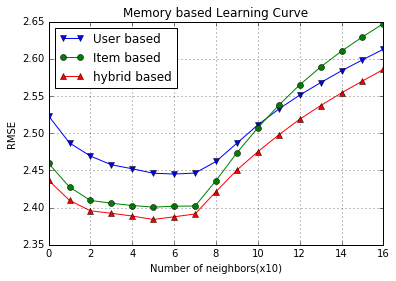

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
k = 17
plt.plot(range(k), rmse_user, marker='v', label='User based')
plt.plot(range(k), rmse_item, marker='o', label='Item based')
plt.plot(range(k), rmse_hybird, marker='^', label='hybrid based')

plt.title('Memory based Learning Curve')
plt.xlabel('Number of neighbors(x10)')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.grid()
plt.show()